In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.metrics import Precision, Recall, AUC, CategoricalAccuracy

from custom_models.augmentation import basic_plus_color_augmentation, basic_augmentation
from custom_models.bilinear_cnns import fe_resnet
from custom_models.cnns import simple_cnn_bn, base_resnet50
from custom_models.optimization_utilities import get_standard_callbacks
from etl.load_dataset import DatasetProcessor, get_tf_eggim_patch_dataset
from optimization.custom_losses import weighted_categorical_crossentropy

2025-01-16 01:25:52.093534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736990752.110869  116664 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736990752.115365  116664 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-16 01:25:52.130767: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
target_dir = '../2025-01_EGGIM_Dataset3'
model_weights_directory = '../logs/'
batch_size = 32
num_epochs = 100
learning_rate = 1e-4
num_folds = 5
name = f'cv_patient_resnet_multi'
model_fold_dir = sorted(os.listdir(model_weights_directory))
model_dirs = [os.path.join(os.path.join(model_weights_directory, x), 'weights.weights.h5')
              for x in model_fold_dir if x.startswith(name)]

In [3]:
model_dirs

['../logs/cv_patient_resnet_multi_65fold_0_20250116-010936/weights.weights.h5',
 '../logs/cv_patient_resnet_multi_65fold_0_20250116-011422/weights.weights.h5',
 '../logs/cv_patient_resnet_multi_65fold_1_20250116-011504/weights.weights.h5',
 '../logs/cv_patient_resnet_multi_65fold_2_20250116-011530/weights.weights.h5',
 '../logs/cv_patient_resnet_multi_65fold_3_20250116-011601/weights.weights.h5',
 '../logs/cv_patient_resnet_multi_65fold_4_20250116-011633/weights.weights.h5',
 '../logs/cv_patient_resnet_multi_65fold_5_20250116-011658/weights.weights.h5',
 '../logs/cv_patient_resnet_multi_65fold_6_20250116-011723/weights.weights.h5',
 '../logs/cv_patient_resnet_multi_65fold_7_20250116-011750/weights.weights.h5',
 '../logs/cv_patient_resnet_multi_65fold_8_20250116-011819/weights.weights.h5']

In [4]:
dp = DatasetProcessor(target_dir)
df = dp.process()
patient_ids = np.load('configs/new_patient_ids.npy', allow_pickle=True)

togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)


In [5]:
from sklearn.metrics import confusion_matrix

from evaluation.metrics import categorical_accuracy

from evaluation.metrics import specificity_per_class

from evaluation.metrics import sensitivity_per_class

metrics = []
y_true_ordinals = []
y_pred_ordinals = []
split = dp.patient_wise_split(df_togas,
                                      df_ipo,
                                      patient_ids,
                                      internal_train_size=0.9,
                                      target_variable='eggim_square',
                                      random_state=42)
for fold, (df_train, df_val, df_test) in enumerate(split):
    tf_test_df = get_tf_eggim_patch_dataset(df_test,
                                            num_classes=3,
                                            preprocess_fn=tf.keras.applications.resnet.preprocess_input)

    tf_test_df = tf_test_df.batch(batch_size)

    n_classes = 3  # Replace with the number of classes you have
    model = base_resnet50(input_shape=(224, 224, 3), n_classes=n_classes)
    # Compile the model with Adam optimizer 13:21
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=[CategoricalAccuracy(name='cat_accuracy'), Precision(name='precision'),
                           Recall(name='recall'),
                           AUC(name='auc')])


    model.load_weights(model_dirs[fold])

    y_true = np.concatenate([y for (_, y) in tf_test_df])
    y_pred = model.predict(tf_test_df)
    y_true_ordinal = np.argmax(y_true, axis=-1) # [0 0 1] -> 2
    y_pred_ordinal = np.argmax(y_pred, axis=-1)
    y_true_ordinals.append(y_true_ordinal)
    y_pred_ordinals.append(y_pred_ordinal)
    y_pred_one_hot = np.zeros_like(y_pred)
    y_pred_one_hot[np.arange(len(y_pred)), np.argmax(y_pred, axis=1)] = 1 # [0.2, 0.2, 0.6] -> [0, 0, 1]
    print(y_pred)
    print(y_pred_ordinal)
    print(y_pred_one_hot)
    conf_matrix = confusion_matrix(y_true_ordinal, y_pred_ordinal,
                                   labels=[0, 1, 2])
    metrics.append([categorical_accuracy(y_true, y_pred_one_hot),
                    specificity_per_class(conf_matrix), sensitivity_per_class(conf_matrix),
                    conf_matrix])

I0000 00:00:1736990754.958253  116664 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9237 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-01-16 01:25:57.449168: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
I0000 00:00:1736990758.718905  116737 service.cc:148] XLA service 0x7aeab80036b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736990758.718918  116737 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-01-16 01:

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


I0000 00:00:1736990762.855177  116737 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)


[[0.05749219 0.22240403 0.72010374]
 [0.0016332  0.06116532 0.93720144]
 [0.0024775  0.10153528 0.8959873 ]
 [0.00385269 0.053381   0.94276625]
 [0.00365513 0.11336123 0.8829837 ]
 [0.1417281  0.08275882 0.775513  ]
 [0.02803906 0.07106929 0.9008916 ]
 [0.00280055 0.03204879 0.96515065]
 [0.00903447 0.19179395 0.79917157]
 [0.01847201 0.0463182  0.93520975]
 [0.01515456 0.18063512 0.80421025]]
[2 2 2 2 2 2 2 2 2 2 2]
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-01-16 01:26:04.345693: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[0.38122797 0.27880943 0.3399626 ]
 [0.1269815  0.30141026 0.57160825]
 [0.27077106 0.20728421 0.5219447 ]
 [0.1632131  0.10679174 0.7299952 ]
 [0.16971858 0.00258271 0.8276987 ]
 [0.01355688 0.25621557 0.73022753]
 [0.03469994 0.08667723 0.8786229 ]
 [0.03963168 0.21602096 0.7443474 ]
 [0.02698625 0.05369876 0.91931504]
 [0.12481258 0.28775355 0.5874339 ]
 [0.45092013 0.32512626 0.22395359]]
[0 2 2 2 2 2 2 2 2 2 0]
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:27: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)
/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-01-16 01:26:10.787060: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1681_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-16 01:26:11.087288: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
[[0.14754535 0.02066241 0.83179224]
 [0.03591707 0.07363568 0.89044726]
 [0.24805886 0.27107823 0.48086283]
 [0.07430986 0.08708341 0.8386067 ]
 [0.14004196 0.05277264 0.8071854 ]
 [0.09338601 0.2628064  0.6438076 ]
 [0.01336325 0.04507937 0.9415574 ]
 [0.14614534 0.16588649 0.6879682 ]
 [0.09270726 0.2742849  0.6330078 ]
 [0.425237   0.20831081 0.36645222]
 [0.04099268 0.17892571 0.7800816 ]
 [0.02857023 0.12703246 0.84439737]
 [0.00641031 0.01549549 0.97809416]
 [0.06819956 0.09826309 0.83353734]
 [0.45992368 0.19958642 0.34048986]]
[2 2 2 2 2 2 2 2 2 0 2 2 2 2 0]
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-01-16 01:26:14.941470: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-16 01:26:17.554726: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1681_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-16 01:26:17.839474: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1688', 4 bytes spill stores, 4 bytes spill loads

2025-01-16 01:26:17.920087: I external/local_xla/xla/stream_executor/cuda/cuda_as

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
[[0.24441814 0.13381979 0.62176204]
 [0.24989818 0.46585804 0.2842438 ]
 [0.15545313 0.37578955 0.46875727]
 [0.14779046 0.24874617 0.60346335]
 [0.07528181 0.13602827 0.78869   ]
 [0.00383501 0.08506984 0.91109514]
 [0.03724576 0.09206546 0.87068874]
 [0.0082629  0.12812738 0.8636097 ]]
[2 1 2 2 2 2 2 2]
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[0.04761116 0.13258788 0.8198009 ]
 [0.08463637 0.41969666 0.49566707]
 [0.02213711 0.18330118 0.7945617 ]
 [0.00888217 0.08234791 0.9087699 ]
 [0.02328803 0.08059202 0.89612   ]
 [0.19996583 0.06754623 0.73248786]
 [0.00769531 0.2596813  0.7326234 ]
 [0.00662585 0.10196916 0.89140505]
 [0.00557743 0.04954974 0.9448728 ]
 [0.06734315 0.48356605 0.4490908 ]
 [0.00321254 0.01623281 0.9805547 ]]
[2 2 2 2 2 2 2 2 2 1 2]
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-01-16 01:26:28.064563: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1681_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-16 01:26:28.669958: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1688', 4 bytes spill stores, 4 bytes spill loads

2025-01-16 01:26:28.835008: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1688', 44 bytes spill stores, 44 bytes spill loads


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
[[0.27173424 0.4123605  0.31590533]
 [0.27377614 0.14465223 0.58157164]
 [0.1346887  0.32661211 0.53869915]
 [0.00197356 0.0158189  0.9822075 ]
 [0.03550347 0.10417595 0.8603206 ]
 [0.00420008 0.03533041 0.9604695 ]]
[1 2 2 2 2 2]
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[6.71050191e-01 9.48925018e-02 2.34057277e-01]
 [3.31779127e-03 5.82003221e-02 9.38481867e-01]
 [1.29212055e-03 4.31320146e-02 9.55575883e-01]
 [1.84126914e-01 2.09182113e-01 6.06690943e-01]
 [1.53026553e-02 5.02451919e-02 9.34452176e-01]
 [3.08299839e-01 1.30160362e-01 5.61539769e-01]
 [2.07253397e-02 2.85834223e-01 6.93440437e-01]
 [5.48849814e-02 1.15449265e-01 8.29665780e-01]
 [4.59288276e-05 1.40742864e-03 9.98546660e-01]
 [3.71500328e-02 3.99643242e-01 5.63206732e-01]
 [2.81892002e-01 2.79753238e-01 4.38354790e-01]]
[0 2 2 2 2 2 2 2 2 2 2]
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-01-16 01:26:36.483765: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-16 01:26:39.022877: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1681_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-16 01:26:39.415339: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1688', 4 bytes spill stores, 4 bytes spill loads

2025-01-16 01:26:39.750444: I external/local_xla/xla/stream_executor/cuda/cuda_as

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
[[0.09342028 0.04263591 0.8639439 ]
 [0.1609699  0.10081608 0.738214  ]
 [0.06044628 0.6903631  0.24919055]
 [0.01122472 0.12943427 0.859341  ]
 [0.00282816 0.04343185 0.95374   ]
 [0.06782135 0.36366522 0.56851345]
 [0.04549344 0.41462338 0.53988314]
 [0.00872047 0.13936442 0.8519151 ]
 [0.01305782 0.13609454 0.8508476 ]
 [0.02429535 0.16978996 0.8059147 ]
 [0.12644285 0.3916278  0.4819293 ]
 [0.02430838 0.12391811 0.8517735 ]]
[2 2 1 2 2 2 2 2 2 2 2 2]
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-01-16 01:26:46.111166: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1681_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-16 01:26:47.029630: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1688', 4 bytes spill stores, 4 bytes spill loads

2025-01-16 01:26:47.119769: I external/local_xla/xla/stream_executor/cuda/cuda_asm_

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
[[6.5424419e-03 4.7120824e-02 9.4633675e-01]
 [2.2331446e-01 1.8677941e-01 5.8990616e-01]
 [6.5087639e-02 2.6982769e-01 6.6508466e-01]
 [2.5603328e-02 4.1965389e-01 5.5474281e-01]
 [6.6992389e-03 4.4737712e-02 9.4856304e-01]
 [5.7093444e-04 1.5571160e-02 9.8385793e-01]
 [5.2159973e-03 1.8188709e-01 8.1289685e-01]
 [2.1164853e-02 6.1441611e-02 9.1739357e-01]
 [6.7401994e-03 5.3072911e-02 9.4018692e-01]
 [3.0308499e-03 2.3700848e-02 9.7326827e-01]
 [1.4738864e-02 1.9141072e-01 7.9385042e-01]
 [8.1706010e-03 2.0135744e-02 9.7169363e-01]
 [2.4051486e-02 1.0496654e-01 8.7098199e-01]]
[2 2 2 2 2 2 2 2 2 2 2 2 2]
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-01-16 01:26:52.998078: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1681_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-16 01:26:53.576142: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1688', 4 bytes spill stores, 4 bytes spill loads

2025-01-16 01:26:53.666842: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1688', 316 bytes spill stores, 316 bytes spill load

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
[[0.31873542 0.22695816 0.45430645]
 [0.08251809 0.5295691  0.38791284]
 [0.02302182 0.55816823 0.41880995]
 [0.05369617 0.21113262 0.7351712 ]
 [0.00943266 0.0465677  0.9439996 ]
 [0.20895943 0.50308883 0.28795174]
 [0.03342428 0.07147002 0.89510566]
 [0.01160545 0.05328893 0.9351056 ]
 [0.23241341 0.07541198 0.6921746 ]
 [0.34149134 0.43918642 0.21932223]
 [0.12180201 0.13838677 0.7398112 ]
 [0.01311289 0.04269737 0.94418967]
 [0.02585752 0.23214366 0.74199885]
 [0.01947005 0.5441292  0.43640077]]
[2 1 1 2 2 1 2 2 2 1 2 2 2 1]
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


IndexError: list index out of range

In [6]:
cat_acc = np.array([x[0] for x in metrics])
spec = np.array([x[1] for x in metrics])
sens = np.array([x[2] for x in metrics])
confs = np.array([x[3] for x in metrics], dtype=object)

/tmp/ipykernel_114445/4237036052.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Cat Acc', 'Spec', 'Sens'])


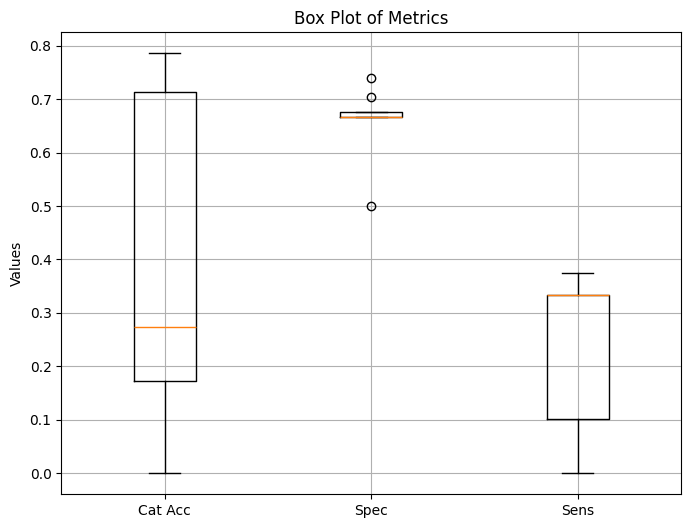

In [ ]:
data = [cat_acc, np.nanmean(spec, axis=1), np.nanmean(sens, axis=1)]

# Create the box plot
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=['Cat Acc', 'Spec', 'Sens'])
plt.title('Box Plot of Metrics')
plt.ylabel('Values')
plt.grid(True)

# Show the plot
plt.show()

In [8]:
from evaluation.eggim import *
def replace_landmark_name(landmark):
    new_landmark_name = {'ii': 'distal body',
                    'ix': 'distal lc',
                    'vi': 'proximal ant lc',
                    'vii': 'proximal ant gc/pw',
                    'viii': 'incisura r',
                    'x': 'upper body r',
                    'xii': 'upper body ant'}
    landmark_number = landmark.split('.')[0]
    return new_landmark_name[landmark_number]

dp = DatasetProcessor(target_dir)
df = dp.process()
df['landmark'] = df['landmark'].apply(replace_landmark_name)
patient_ids = np.load('configs/new_patient_ids.npy', allow_pickle=True)

togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)


In [ ]:
def compute_eggim_patient(patient_df, target_variable):
    df = patient_df[['landmark', target_variable]].value_counts()
    # we use index[0] to assume first landmark/score pair is correct
    eggim_antrum_incisura = df['proximal ant lc'].index[0] + df['proximal ant gc/pw'].index[0] + df['incisura r'].index[0]
    eggim_body_1 = (df['distal body'].index[0] + df['upper body ant'].index[0]) / 2
    eggim_body_2 = (df['distal lc'].index[0]+ df['upper body r'].index[0]) / 2
    return eggim_antrum_incisura + eggim_body_1 + eggim_body_2

eggim_scores = {}
for i, patient_id in enumerate(patient_ids):
    print(patient_id)
    df_patient = df_togas[df_togas['patient_id'] == patient_id]
    df_patient['pred'] = y_pred_ordinals[i]
    eggim_square = compute_eggim_patient(df_patient,
                                          target_variable='eggim_square')
    eggim_global = compute_eggim_patient(df_patient,
                                  target_variable='eggim_global')
    eggim_pred = compute_eggim_patient(df_patient,
                                  target_variable='pred')
    eggim_scores[patient_ids[i]] = {'eggim_square': eggim_square, 'eggim_global': eggim_global,
                                    'eggim_pred': eggim_pred}
eggim_df = pd.DataFrame(eggim_scores).T

PT004
PT005
PT006
PT009
PT016
PT020
PT021
PT022


/tmp/ipykernel_114445/2628975875.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patient['pred'] = y_pred_ordinals[i]
/tmp/ipykernel_114445/2628975875.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patient['pred'] = y_pred_ordinals[i]
/tmp/ipykernel_114445/2628975875.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [ ]:
eggim_df

,eggim_square,eggim_global,eggim_pred
PT004,1.0,1.0,9.0
PT005,3.0,2.5,10.0
PT006,1.0,1.0,10.0
PT009,8.0,8.5,10.0
PT016,0.0,0.0,10.0
PT020,1.0,2.0,8.0
PT021,8.0,8.0,10.0
PT022,8.0,8.0,10.0


In [11]:
# minimum error of patch vs global labels
best_possible_eggim_mae = np.mean(np.abs(eggim_df.iloc[:, 1] -  eggim_df.iloc[:, 0]))

In [12]:
# error of patch predictions vs patch labels
patch_eggim_mae =  np.mean(np.abs(eggim_df.iloc[:, 0] -  eggim_df.iloc[:, 2]))

In [13]:
patch_global_eggim_mae = np.mean(np.abs(eggim_df.iloc[:, 1] -  eggim_df.iloc[:, 2]))

In [ ]:
patch_eggim_mae

5.875

In [ ]:
# patch ground truth vs patch pred:
patch_eggim_mae

5.875

In [ ]:
# global ground truth vs patch pred
patch_global_eggim_mae

5.75

In [ ]:
# global ground truth vs patch pred "adjusted" with minimum error in square labels
patch_global_eggim_mae - best_possible_eggim_mae

5.5

In [ ]:
best_possible_eggim_mae

0.25